# Machine Learning Programming Exercise 3: Neural Networks

In [1]:
#import package(s)
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio 
import math

## 2 Multi-class Classiﬁcation using Neural Networks
This part of the exercise uses neural networks to recognize handwritten digits (from $0$ to $9$). The neural network will be able to represent complex models that form nonlinear hypotheses. Previously trained parameters from a neural network are provided. The goal is to implement the feedforward propagation algorithm on the weights (theta parameters) for prediction.

<div class="alert alert-block alert-info">
<b>Note:</b> If there are too many features, it is difficult to learn complex nonlinear hypotheses using simple logistic regression with quadratic (second-order) and cubic (third-order) polynomial terms of the combinations of those features. In addition, this can be computationally expensive to train and may end up overfitting the training set. 
    
For example, if $n=100$, then we have the features $x_1, x_2, \dots, x_{100}$. We end up with $5000$ features that are quadratic for the complex model: $g(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + \cdots + \theta_{100} x_{100} + \theta_{101} x_1^2 + \theta_{102} x_1 x_2 + \cdots + \theta_{200} x_1 x_{100} + \theta_{201} x_2^2 + \theta_{202} x_2 x_3 + \cdots)$. If the model were to also include cubic polynomial terms, then we would end up with $170,000$ features.

A neural network has the advantage of learning its own features by using the inputs, which can give better hypotheses than being contrained to use raw features or polynomial terms for logistic regression. This algorithm has the ﬂexibility to try to learn whatever features at once to feed to the hypothesis function.
</div>

### 2.1 Dataset
The file ex3data1.mat contains 5000 training examples from the MNIST handwritten digit dataset. Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Every row of the feature matrix $X$ is a training example for a handwritten digit image.

The 5000-dimensional vector $y$ contains labels for the training set. Due to indexing, the digit zero is mapped to the value ten while the other digits are mapped as normal. That is, a "$0$" digit is labeled as "$10$".

In [2]:
#Setup the parameters you will use for this part of the exercise

#20x20 Input Images of Digits
input_layer_size  = 400  

#25 hidden units
hidden_layer_size = 25   

#10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10       

### 2.2 Visualizing the data
A subset of the training set is visualized by randomly selecting 100 rows from the matrix $X$ and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

Loading and Visualizing Data ...



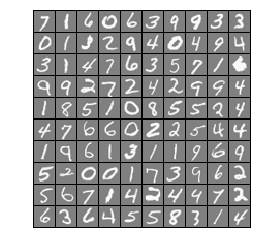

In [3]:
#define function for exercise(s)
def displayData(X):
#DISPLAYDATA Display 2D data in a nice grid
    example_width = int(round(math.sqrt(X.shape[1])))

    # Compute rows, cols
    m,n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    row_initial = pad + display_rows*(example_height + pad)
    col_initial = pad + display_cols*(example_width + pad)
    display_array = -(np.ones((row_initial, col_initial)))

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j  in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break 
            # Copy the patch
            
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex, :]))
            
            row_arr = list(map(lambda x:x+pad+j*(example_height + pad), range(example_height+1)))
            col_arr = list(map(lambda x:x+pad+i*(example_width + pad), range(example_width+1)))
            display_array[row_arr[0]:row_arr[-1], col_arr[0]:col_arr[-1]] = np.reshape(X[curr_ex, :], (example_height, example_width)) / max_val
            curr_ex = curr_ex + 1
            
        if curr_ex > m:
            break
    # Display Image
    h = plt.imshow(display_array.T, clim = (-1,1))
    # gray scale the image
    h.set_cmap('gray')
    # Do not show axis
    plt.axis('off')
    plt.show()

# =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset.
#  You will be working with a dataset that contains handwritten digits.

#Loading and Visualizing Data 
print('Loading and Visualizing Data ...\n')
data = sio.loadmat('ex3data1.mat')
#training data stored in the arrays X, y
X = data['X']
y = data['y']

#m is the number of rows of X
m = X.shape[0]

#Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

displayData(sel)

### 2.3 Model representation
The model for the neural network will have three layers: an input layer, a hidden layer and an output layer. 

The input layer is the inputs or features for the model, which are pixel values of digit images. Since the images are of size $20\times20$, this gives $400$ input layer units (excluding the extra bias unit, $x_0$, which always output $+1$). 

The hidden layer is between the input an output layer. In this layer, the activation units are computed. 

The output layer is the outputs or results of the hypothesis function, which is the digits from $1$ to $10$. The sigmoid (logistic) function is used and is often called the sigmoid activiation function. 

Image source: ex3.pdf from Andrew Ng's Coursera course in Machine Learning
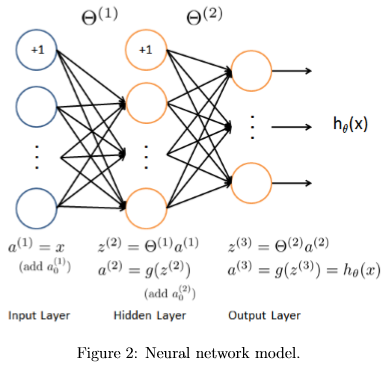

The set of trained parameters $(\Theta^{(1)}, \Theta^{(2)})$ are given. $\Theta^{(1)}$ is of size $25\times401$ for the $25$ activation units in the second layer and the $400$ input units plus the bias unit in the input layer. $\Theta^{(2)}$ is of size $10\times26$ for the $10$ units in the output layer and the $25$ activation units plus the bias unit in the hidden layer. 

Recall, the vector representation of $x$ and $z^j$ for layer $j$ and $n$ units is
$x = \begin{bmatrix}
       x_0 \\
       x_1 \\
       \vdots \\
       x_{n}
       \end{bmatrix}, \quad z^{(j)} = \begin{bmatrix}
       z_1^{(j)} \\
       z_2^{(j)} \\
       \vdots \\
       z_{n}^{(j)}
       \end{bmatrix}$,
where 
$z_k^{(j)} = \Theta_{k,0}^{(j-1)} x_0 + \Theta_{k,1}^{(j-1)} x_1 + \dots + \Theta_{k,n}^{(j-1)} x_n$ for layer $j$ and node $k$.

In [4]:
# ================ Part 2: Loading Pameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('Loading Saved Neural Network Parameters ...\n')

#Load the weights into variables Theta1 and Theta2
wts = sio.loadmat('ex3weights.mat')
T2 = wts['Theta2']
T1 = wts['Theta1']

Loading Saved Neural Network Parameters ...



### 2.4 Feedforward Propagation and Prediction

The feedforward computation computes $h_{\theta}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $(h_{\theta}(x))_{k}$ where $k$ represents one of the $10$ classes ($k = \{1, 2, \dots, 10\}$).

<div class="alert alert-block alert-info">
<b>Note:</b>  
The setup looks like this:
    $x = \begin{bmatrix}
       x_0 \\
       x_1 \\
       \vdots \\
       x_{400}
       \end{bmatrix} \to \begin{bmatrix}
       a_0^{(2)} \\
       a_1^{(2)} \\
       \vdots \\
       a_{25}^{(2)}
       \end{bmatrix} \to \begin{bmatrix}
       a^{(3)} 
       \end{bmatrix} \to h_{\theta}(x)$.
</div>

The accuracy should be about $97.5\%$. After that, an interactive sequence will launch displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image. To stop the image sequence, press 'q'.

<div class="alert alert-block alert-info">
<b>Implementation Note:</b>  
Add a column of ones to the matrices for the bias unit. The matrices Theta1 and Theta2 contain the parameters for each unit in rows. Transpose these matrices when necessary for the matrix calculations. 
    
</div>


Training Set Accuracy:  97.52
Expected Accuracy: 97.5 (approx) 


Displaying Example Image


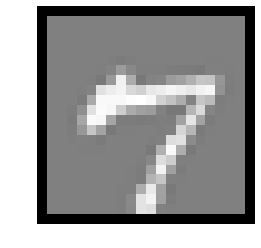

Neural Network Prediction: 7 (digit 7)
Paused - press enter to continue, q to exit: 

Displaying Example Image


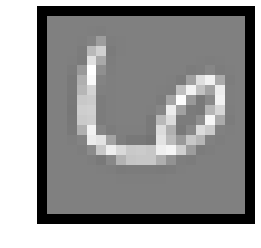

Neural Network Prediction: 6 (digit 6)
Paused - press enter to continue, q to exit: 

Displaying Example Image


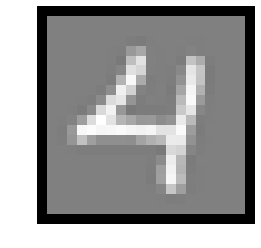

Neural Network Prediction: 4 (digit 4)
Paused - press enter to continue, q to exit: 

Displaying Example Image


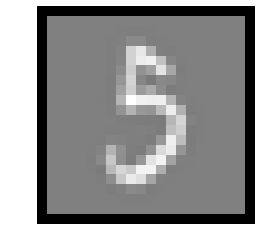

Neural Network Prediction: 5 (digit 5)
Paused - press enter to continue, q to exit: 

Displaying Example Image


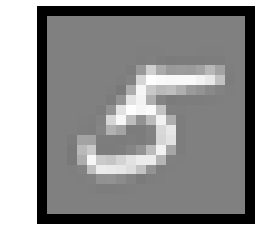

Neural Network Prediction: 5 (digit 5)
Paused - press enter to continue, q to exit: q


In [5]:
#define function for exercise(s)
def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

def predict(Theta1, Theta2, X):
#PREDICT Predict the label of an input given a trained neural network
#   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#   trained weights of a neural network (Theta1, Theta2)

    #Useful values
    m = X.shape[0]
    #Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))
    #calculate the hidden units in layer 2 of the neural network
    a1 = X
    z2 = np.matrix(a1)*np.matrix(T1.T)
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones((m,1)), a2))
    z3 = np.matrix(a2)*np.matrix(T2.T)
    #h is size X.shape[0] by T2.shape[0]
    h = sigmoid(z3)
    #find the indices of the maximum value of each row in the matrix h
    #then add 1 to get the right label
    p = np.nanargmax(h, axis=1) + 1
    return p
    #return np.reshape(p, (-1, 1)) for arrays

def oneExAtATime(Theta1, Theta2, X, sample):
#ONEEXATATIME show one example at a time
    m = X.shape[0]
    for i in range(0,m):
        #Display 
        print('\nDisplaying Example Image')
        #reshape into a row vector
        one_ex = np.reshape(X[sample[i],:], (1,-1))
        displayData(one_ex)
        pred = predict(Theta1, Theta2, one_ex)
        print('Neural Network Prediction: %s (digit %s)' % (int(pred), int(pred % 10)))
        if pred == 10:
            print('We have mapped "0" to label 10')
        #Pause with quit option
        s = input('Paused - press enter to continue, q to exit: ')
        if s == 'q':
            break

# ================= Part 3: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(T1, T2, X)

print('Training Set Accuracy: ', (np.mean(np.equal(pred,y)))*100)
print('Expected Accuracy: 97.5 (approx) \n')

#To give you an idea of the network's output, you can also run
#through the examples one at the a time to see what it is predicting.

#Randomly permute examples
rp = np.random.permutation(m)
#Display image and prediction of value
oneExAtATime(T1, T2, X, rp)